# Import modules

In [ ]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from scipy.sparse import diags
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seeds
random.seed(1)
np.random.seed(1)

torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ativate GPU if needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Get latex commands
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
plt.rcParams['text.usetex'] = True

# Define initial parameters

In [ ]:
#Space grid (same for all dimension), nleft bound, right bound, and number of points
lb = 0
rb = 1
n_x = 32

#Define data points number
m = 200

#Data oscillations (how many sin/cos waves to superpose) and initial coeficient bound
c_1 = 20
k = 4

#Number of output times
t_k = 10

#Boundary conditions type (inactive for now - Dirichlet zero boundaries in place)
Boundary_cond = 'Dirichlet'
#Boundary conditions if Dirichlet (inactive for now - Dirichlet zero boundaries in place)
T_0 = 0
T_1 = 0

#Coefficients cap
max_a = 2.5
max_b = 2.5
#Epsilon value (for coefficient and model parameter caps)
epsilon = 0.0001

#Maximum coarsening factor for experiments
coars_max = 8

#Optimization parameters: regularization, batch size, train-val-test percentage split
batch_s = 32
train_size = 0.75
val_size = 0.125

#Example soltution to plot
test_data = 19

# Define mesh, particular to the heat equation: $dt \sim dx^2$

We pick $n_t = 2\cdot dimension \cdot max(a(x,y))\cdot n_x^2$ and this will ensure stability of the Finite Differences algorithm since $\frac{a(x,y)d_t}{d_x^2} \leq \frac{max(a(x,y))d_t}{d_x^2} = \frac{1}{2\cdot dimension}$

In [ ]:
#Define space and time mesh
n_t = int(4*max_a*n_x*n_x)

xmesh = torch.linspace(lb, rb, n_x).to(device)
tmesh = torch.linspace(0, 1, n_t).to(device)

dx = xmesh[1]-xmesh[0]
dt = tmesh[1]-tmesh[0]

In [ ]:
dt/dx

tensor(0.0030, device='cuda:0')

# Define random initial conditions

Made up of a superposition of k (hyperparameter defined above) sin waves




In [ ]:
# Random initial conditions made up of a combination of sin(pi*k*x) functions - decaying as 1/k
x1, x2 = np.meshgrid(xmesh.cpu(), xmesh.cpu())
def sin_xy(x,y,i,j):
  return np.sin(np.pi*i*x)*np.sin(np.pi*j*y)

coef_vector = torch.ones((k,k)).to(device)
for i in range(k):
  for j in range(k):
    if ((i<=1) and (j<=1)):
      coef_vector[i][j] = 1
    else:
      coef_vector[i][j] = 0

def initial_cond_dirichlet(x_mesh,k):
  coefs_rand = (torch.rand((k,k))-0.5).to(device)
  coefs_actual = coef_vector*coefs_rand
  func=torch.zeros((len(x_mesh),len(x_mesh))).to(device)
  for i in range(1, k+1):
    for j in range(1,k+1):
      func+=(coefs_actual[i-1][j-1]*torch.tensor(sin_xy(x1,x2,i,j)).to(device))

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual

## Define the coeficients for the equatiion to model: $u_t = a(x,y)(u_{xx}+u_{yy})$

Capped between max_a and zero to ensure stability (hyperparameters defined above). The epsilon value just ensures the caps are not attained so that the model can learn the parameters exactly





In [ ]:
#Define 2D grid and return evaluated coefficient values
a_xy = initial_cond_dirichlet(xmesh,k)[0].to(device)+0.75
a_xy = torch.maximum(torch.minimum(a_xy, torch.tensor(max_a - epsilon)), torch.tensor(epsilon))

b_x = initial_cond_dirichlet(xmesh, k)[0].to(device)
b_y = initial_cond_dirichlet(xmesh, k)[0].to(device)

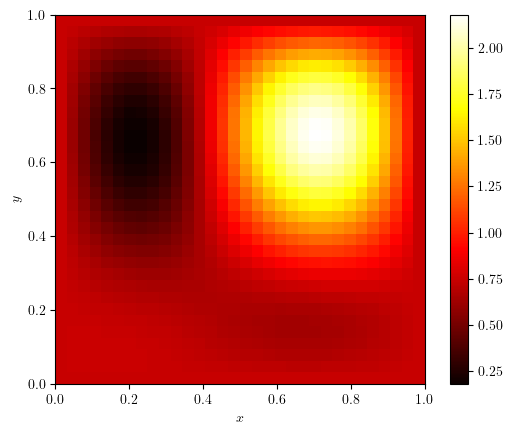

In [ ]:
#Visualize the coefficients (also an example of initial conditions)
plt.imshow(a_xy.cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [ ]:
#Construct the data of initial conditions
coefficients = torch.zeros((m, k, k)).to(device)
initial_conditions = torch.zeros(m, n_x, n_x).to(device)
for j in range(m):
  function, coefs = initial_cond_dirichlet(xmesh, k)
  initial_conditions[j]= function
  coefficients[j] = coefs

# Fully resolved finite difference method, later coarsened
- first run the fully resolved FD method
- then averaged down to coarse mesh
- average in space x-factor adjacent grid points
- sample in time, (the t-factor time step)


In [ ]:
#Define inputs and outputs of neural net which are PDE intitial condition and averaged solution at t=1,..,t_k respectively

#Maximum time value to generate data for
t_max = coars_max*t_k+1
solutions_exact = torch.zeros((1, t_max, n_x, n_x)).to(device)

filter = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]]).float().to(device)
one_filter = torch.tensor([[1]]).float().to(device)
#Loop over all initial conditions (data points)
for j in range(m):
  #Create FD solution with initial condition
  sol = torch.zeros((t_max, n_x, n_x)).to(device)
  sol[0]=initial_conditions[j]

  #Solve forward in time (full grid) using finite differences
  for i in range(1, t_max):
    inp_pad = F.pad(sol[i-1].unsqueeze(0), (1,1,1,1), mode='circular')
    convolution = F.conv2d(inp_pad, filter.unsqueeze(0).unsqueeze(0), padding = 0)
    a_xy_prime = convolution*a_xy
    upwind = torch.maximum(b_x,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(-1), dims=(-1))-sol[i-1]) + torch.maximum(b_y,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(-1), dims=(-2))-sol[i-1])

    downwind = -torch.minimum(b_x,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(1), dims=(-1))-sol[i-1]) - torch.minimum(b_y,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(1), dims=(-2))-sol[i-1])
    sol[i] = sol[i-1] + upwind + downwind + dt/(dx**2)*a_xy_prime

  #Add to solutions tensor
  solutions_exact = torch.cat((solutions_exact, sol.view(1, t_max, n_x, n_x)), 0)

In [ ]:
#Construct the OOD data from a different spectrum
OOD_spec = torch.ones((k,k)).to(device)
for i in range(k):
  for j in range(k):
    if ((i>=2) and (j>=2)):
      OOD_spec[i][j] = 1
    else:
      # OOD_spec[i][j] = 1/(np.sqrt((3-i)**2+(3-j)**2))
      OOD_spec[i][j] = 0

def initial_cond_OOD(x_mesh,k):
  coefs_rand = (torch.rand((k,k))-0.5).to(device)
  coefs_actual = OOD_spec*coefs_rand
  func=torch.zeros((len(x_mesh),len(x_mesh))).to(device)
  for i in range(1, k+1):
    for j in range(1,k+1):
      func+=(coefs_actual[i-1][j-1]*torch.tensor(sin_xy(x1,x2,i,j)).to(device))

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual

coefficients_OOD = torch.zeros((50, k, k)).to(device)
initial_conditions_OOD = torch.zeros(50, n_x, n_x).to(device)
for j in range(50):
  function, coefs = initial_cond_OOD(xmesh, k)
  initial_conditions_OOD[j]= function
  coefficients_OOD[j] = coefs

In [ ]:
#Define an out of distribution data point (i.e. 2 oscillations instead of 4)
solutions_exact_OOD = torch.zeros((1,t_max,n_x,n_x)).to(device)

for j in range(50):
  sol = torch.zeros((t_max,n_x,n_x)).to(device)
  sol[0]=initial_conditions_OOD[j]

  for i in range(1, t_max):
    inp_pad = F.pad(sol[i-1].unsqueeze(0), (1,1,1,1), mode='circular')
    convolution = F.conv2d(inp_pad, filter.unsqueeze(0).unsqueeze(0), padding = 0)
    a_xy_prime = convolution*a_xy*dt/(dx**2)
    upwind = torch.maximum(b_x,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(-1), dims=(-1))-sol[i-1]) + torch.maximum(b_y,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(-1), dims=(-2))-sol[i-1])

    downwind = -torch.minimum(b_x,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(1), dims=(-1))-sol[i-1]) -torch.minimum(b_y,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],shifts=(1), dims=(-2))-sol[i-1])

    sol[i] = sol[i-1] + upwind + downwind + a_xy_prime

  solutions_exact_OOD = torch.cat((solutions_exact_OOD, sol.view(1,t_max,n_x,n_x)), 0)

##Coarsening:

Coarsen the space grid by x_factor defined below and sample solutions at the t_factor which corresponds to $x\_factor^2$ for stability

In [ ]:
#Factor by which to coarsen x-grid and new number of grid points (for easier to read code later)
x_factor = 2
n_x_new = int(n_x/x_factor)
#Corresponding t_factor
t_factor = x_factor

In [ ]:
from traitlets.config.application import T
#Define the coarsening function using pooling layers and ensuring the Dirichlet zero boundary conditions
def coarsen(sol, n_x, x_factor):
  sol_avg = torch.zeros((t_k, n_x_new, n_x_new)).to(device)

  #For each output average pool the values and then add the boundary conditions
  for t in range(t_k):
    sol_avg[t] = F.avg_pool2d(sol[t_factor*(t+1)].unsqueeze(0),x_factor)
    # sol_avg[t] = F.pad(sol_avg[t,1:-1,1:-1].unsqueeze(0), (1,)*4, mode='circular')
    #for i in range(n_x_new):
    #  sol_avg[t][i][0] = 0
    #  sol_avg[t][i][-1] = 0
    #sol_avg[t][0] = torch.zeros(n_x_new)
    #sol_avg[t][-1] = torch.zeros(n_x_new)

  #For the iput average pool the values and then add the boundary conditions
  inp_avg = F.avg_pool2d(sol[0].unsqueeze(0),x_factor)
  # inp_avg = F.pad(inp_avg[0,1:-1,1:-1].unsqueeze(0), (1,)*4, mode='circular')
  #for i in range(n_x_new):
  #  inp_avg[0][i][0] = 0
  #  inp_avg[0][i][-1] = 0
  #inp_avg[0][0] = torch.zeros(n_x_new)
  #inp_avg[0][-1] = torch.zeros(n_x_new)

  return inp_avg, sol_avg


In [ ]:
#Define the inputs and outputs of the model (inputs are the initial conditons coarsened and
#outputs are the outputs at the sampled times coarsened in space too)
inputs = torch.zeros((1, n_x_new, n_x_new)).to(device)
outputs = torch.zeros((1, t_k, n_x_new, n_x_new)).to(device)

for j in range(1, m+1):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact[j], n_x, x_factor)

  #Conactenate our input-output pair to the respective tensors
  inputs = torch.cat((inputs, inp_avg.view(1, n_x_new, n_x_new)), 0)
  outputs = torch.cat((outputs, sol_avg.view(1, t_k, n_x_new, n_x_new)),0)

# Format data into pytorch data_loaders

In [ ]:
# Add an extra dimension to inputs for mathematical stability of matrices
inputs = torch.unsqueeze(inputs,1)

In [ ]:
# Chek input and output sizes
print(inputs.size())
print(outputs.size())

torch.Size([201, 1, 16, 16])
torch.Size([201, 10, 16, 16])


In [ ]:
# Format data into datsets and then load them as dataloaders with batch size 16 (this can change)
Data_heat = TensorDataset(inputs, outputs)

Data_heat_train, Data_heat_val, Data_heat_test = torch.utils.data.random_split(Data_heat,
 [int(m*train_size)+1, int(m*val_size), m-int(m*train_size)-int(m*val_size)])

Heat_DataLoader_train = DataLoader(Data_heat_train, batch_size=batch_s, shuffle=True)
Heat_DataLoader_val = DataLoader(Data_heat_val, batch_size=batch_s, shuffle=True)
Heat_DataLoader_test = DataLoader(Data_heat_test, batch_size=batch_s, shuffle=True)

In [ ]:
#Define inputs and outputs
inputs_OOD = torch.zeros((1,n_x_new, n_x_new)).to(device)
outputs_OOD = torch.zeros((1,t_k,n_x_new, n_x_new)).to(device)

for j in range(50):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact_OOD[j], n_x, x_factor)

  #Conactenate our input-output pair to the respective tensors
  inputs_OOD = torch.cat((inputs_OOD, inp_avg.view(1,n_x_new,n_x_new)), 0)
  outputs_OOD = torch.cat((outputs_OOD, sol_avg.view(1,t_k,n_x_new,n_x_new)),0)

inputs_OOD = torch.unsqueeze(inputs_OOD,1)

In [ ]:
# Format data into datsets and then load them as dataloaders
Data_heat_OOD = TensorDataset(inputs_OOD, outputs_OOD)
Heat_DataLoader_OOD = DataLoader(Data_heat_OOD, batch_size=batch_s, shuffle=True)

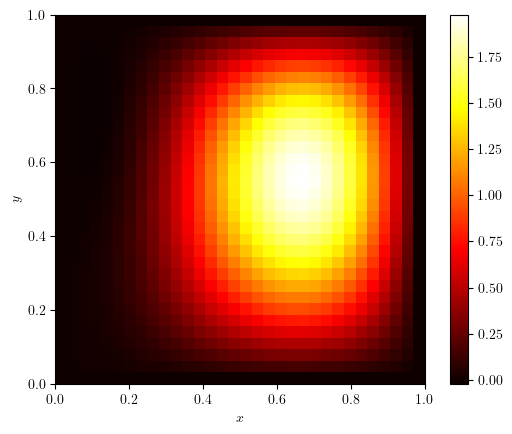

In [ ]:
#Subgrid example for Thesis
fine = solutions_exact[77]
coarse, _ = coarsen(fine, n_x, x_factor)

#Visualize the coefficients (also an example of initial conditions)
plt.imshow(fine.cpu()[0], cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

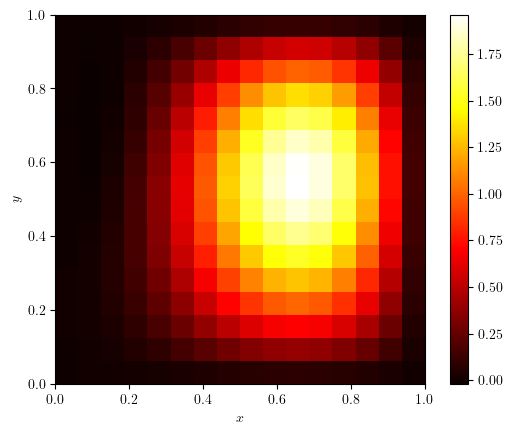

In [ ]:
#Thesis - coarsening
plt.imshow(coarse.cpu()[0], cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [ ]:
from numpy.lib.twodim_base import vander
from numpy.lib.shape_base import apply_over_axes
# Define the Coarsened FD method as a neural net
class IndividualLayer_PDE(nn.Module):
  """This class implements an individual layer of the coarsened grid FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(IndividualLayer_PDE, self).__init__()

    #Define convolution filter corresponding to the heat equation partial derivatives
    self.filter = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]]).float().to(device)

    # Initialize parameters randomly in (-0.5, 0.5)
    # self.coefs_a = torch.nn.Parameter(2.5*(torch.rand(grid_size, grid_size)-0.5))
    # self.coefs_bx = torch.nn.Parameter(2.5*(torch.rand(grid_size, grid_size)-0.5))
    # self.coefs_by = torch.nn.Parameter(2.5*(torch.rand(grid_size, grid_size)-0.5))

    self.coefs_a = torch.nn.Parameter(torch.FloatTensor(grid_size, grid_size).uniform_(-0.001, 0.001))
    self.coefs_bx = torch.nn.Parameter(torch.FloatTensor(grid_size, grid_size).uniform_(-0.001, 0.001))
    self.coefs_by = torch.nn.Parameter(torch.FloatTensor(grid_size, grid_size).uniform_(-0.001, 0.001))

  def forward(self, v):
    """
      x: Tensor
        Coarsened inputs at a given time

      Outputs: Returns the predicted coarsened outputs at the next time
    """
    # Bound coeficients between zero and max_a for stability
    a_xy = max_a*torch.sigmoid(self.coefs_a)
    b_x = max_b*torch.tanh(self.coefs_bx)
    b_y = max_b*torch.tanh(self.coefs_by)
    # b_x = self.coefs_bx
    # b_y = self.coefs_by


    # Implement the FD method on the coarsened grid (to learn parameters through back-propagation) - same as when generating the non-coarsened data
    inp_pad = F.pad(v, (1,1,1,1), mode='circular')
    #print("inppad",torch.linalg.norm(inp_pad))
    convolution = F.conv2d(inp_pad, self.filter.unsqueeze(0).unsqueeze(0), padding = 0)
    #print("conv",torch.linalg.norm(convolution))

    a_xy_prime = convolution*a_xy*dt/(dx**2)

    upwind = torch.maximum(b_x,torch.tensor(0))*dt/dx*(torch.roll(v, shifts=(-1), dims=(-1))-v) + torch.maximum(b_y,torch.tensor(0))*dt/dx*(torch.roll(v,shifts=(-1), dims=(-2))-v)

    downwind = -torch.minimum(b_x,torch.tensor(0))*dt/dx*(torch.roll(v, shifts=(1), dims=(-1))-v) -torch.minimum(b_y,torch.tensor(0))*dt/dx*(torch.roll(v,shifts=(1), dims=(-2))-v)

    y = v + (a_xy_prime)/x_factor + (upwind + downwind)
    return y

In [ ]:
from math import nextafter
class PDE_Solver(nn.Module):
  """This class implements the Full Coarsened FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(PDE_Solver, self).__init__()

    # Call the individual layer class defined previously
    self.layer = IndividualLayer_PDE(grid_size)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs to the network at time 0

      Outputs: Returns the coarsened outputs at the next t_k times
    """

    # Call the individual layer (FD method) t_k times to generate the next t_k time predictions in the coarsened grid
    # and concatenate the new value to the output tensor
    prev = x
    next = self.layer(prev)
    y = next
    prev = next

    for i in range(t_k-1):
      next = self.layer(prev)
      y = torch.cat((y,next),1)
      prev = next

    return y

# Define the Training and Validation for the model

In [ ]:
# Define one training epoch through the train and valudate functions
# Each call to train and validate runs a training and validation epoch
# This is generic code that serves to train and validate any ML model with Pytorch
def train(model, dataloader, optimizer, criterion):
    train_loss = 0.
    model.train()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(source)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_time = end - start
    return train_loss, train_time

def validate(model, dataloader, criterion):
    val_loss = 0.
    model.eval()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output = model(source)
        loss = criterion(output, target)
        val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_time = end - start
    return val_loss, val_time

# Run it / Train the Model and plot learning dynamics


In [ ]:
# Define the model as the PDE_Solver class and feed in the coarsed grid size
# Optimize with Adam and our loss is the L_2 loss
model = PDE_Solver(n_x_new).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
results = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 2000

    for epoch in range(n_epochs):
        train_loss, train_time = train(model, Heat_DataLoader_train, optimizer, criterion)
        valid_loss, valid_time = validate(model, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_times"].append(valid_time)

    test_loss, test_time = validate(model, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_time"] = test_time

Streaming output truncated to the last 5000 lines.
Valid Loss: 1.5486330084968358e-05 | Valid Time: 0.009
Epoch: 334
Train Loss: 1.5338412413257175e-05 | Train Time: 0.129
Valid Loss: 1.5385809092549607e-05 | Valid Time: 0.010
Epoch: 335
Train Loss: 1.5338453704316634e-05 | Train Time: 0.130
Valid Loss: 1.52864904521266e-05 | Valid Time: 0.009
Epoch: 336
Train Loss: 1.5113821064005606e-05 | Train Time: 0.123
Valid Loss: 1.5186854398052674e-05 | Valid Time: 0.009
Epoch: 337
Train Loss: 1.5059384350024629e-05 | Train Time: 0.138
Valid Loss: 1.5089939552126452e-05 | Valid Time: 0.009
Epoch: 338
Train Loss: 1.4931000259821304e-05 | Train Time: 0.122
Valid Loss: 1.499286008765921e-05 | Valid Time: 0.011
Epoch: 339
Train Loss: 1.4813367670285515e-05 | Train Time: 0.127
Valid Loss: 1.4896056200086605e-05 | Valid Time: 0.009
Epoch: 340
Train Loss: 1.479586680943612e-05 | Train Time: 0.130
Valid Loss: 1.4801034922129475e-05 | Valid Time: 0.009
Epoch: 341
Train Loss: 1.4712396841787268e-05 | Tra

Text(0, 0.5, 'MSE')

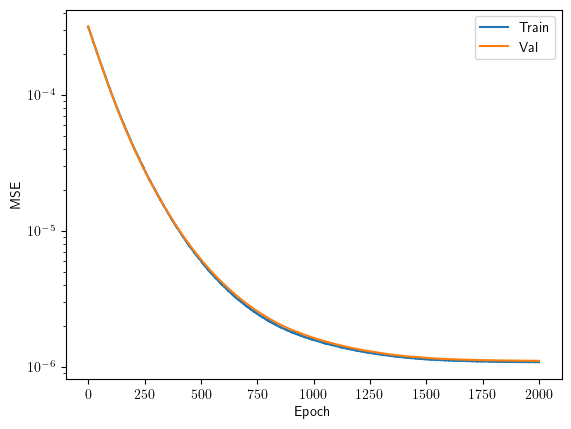

In [ ]:
# Plot the training and validation losses
plt.plot(results["train_losses"])
plt.plot(results["valid_losses"])
plt.legend(['Train', 'Val'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
# # Print the learned parameters and collect the coeafficients found by the model
# results_coefs_a = np.zeros((n_x_new,n_x_new))
# for i, param in enumerate(model.parameters()):
#   print(param)
#   if i ==0:
#     for j1 in range(n_x_new):
#       for j2 in range(n_x_new):
#         results_coefs_a[j1][j2]=2*max_a*torch.tanh(param[j1][j2])

In [ ]:
for i, param in enumerate(model.parameters()):
  if i == 0:
    results_coefs_a = max_a*torch.sigmoid(param.cpu())
  elif i == 1:
    results_coefs_bx = max_b*torch.tanh(param.cpu())
  else:
    results_coefs_by = max_b*torch.tanh(param.cpu())

results_coefs_a = results_coefs_a.detach().numpy()
results_coefs_bx = results_coefs_bx.detach().numpy()
results_coefs_by = results_coefs_by.detach().numpy()

# Plot learned coefficients agains actual coeficients

We use interpolation when comparing soltuions for more coarsened grids

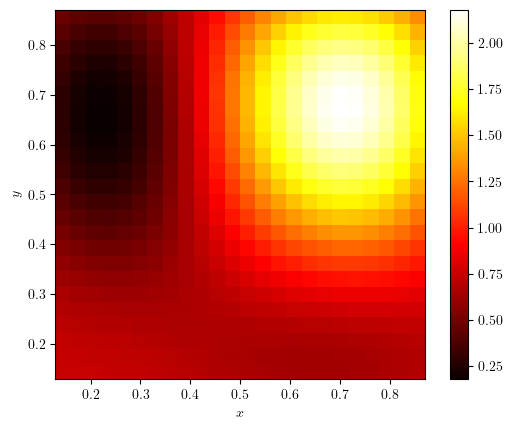

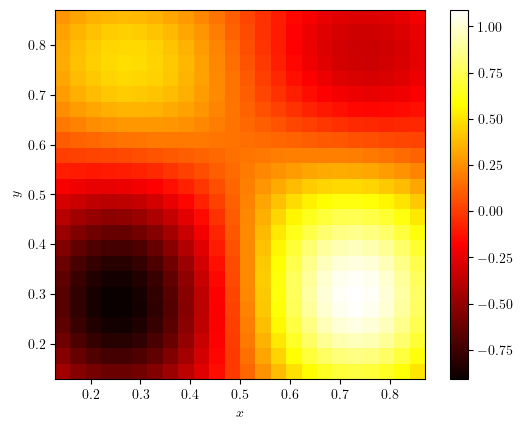

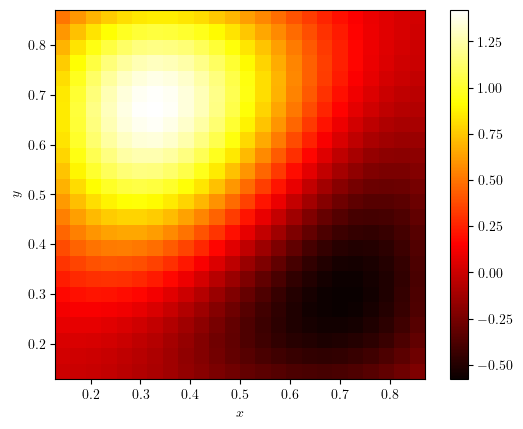

In [ ]:
#Visualize actual coefficients again
plt.imshow(a_xy.cpu()[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

plt.imshow(b_x.cpu()[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

plt.imshow(b_y.cpu()[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
import scipy
#Get the averaged mesh values in one dimension (since it is a rectangular grid it is the same in all dimensions)
x_mesh_avg = torch.zeros(n_x_new).to(device)
for i in range(n_x_new):
  x_mesh_avg[i] = torch.mean(xmesh[x_factor*i:x_factor*(i+1)])
x_mesh_avg[0]=0
x_mesh_avg[-1]=1

In [ ]:
#Interpolate the results to the fine grid using linear interpolation (excluding last two coeficients due to boundary condition redundancy)
interp2d_coefs = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                           results_coefs_a, bounds_error=False, fill_value=None)
interpolated_coefs_a = interp2d_coefs((x2, x1))

In [ ]:

#Interpolate the results to the fine grid using linear interpolation (excluding last two coeficients due to boundary condition redundancy)
interp2d_coefs_bx = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                           results_coefs_bx, bounds_error=False, fill_value=None)
interpolated_coefs_bx = interp2d_coefs_bx((x2, x1))

#Interpolate the results to the fine grid using linear interpolation (excluding last two coeficients due to boundary condition redundancy)
interp2d_coefs_by = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                           results_coefs_by, bounds_error=False, fill_value=None)
interpolated_coefs_by = interp2d_coefs_by((x2, x1))

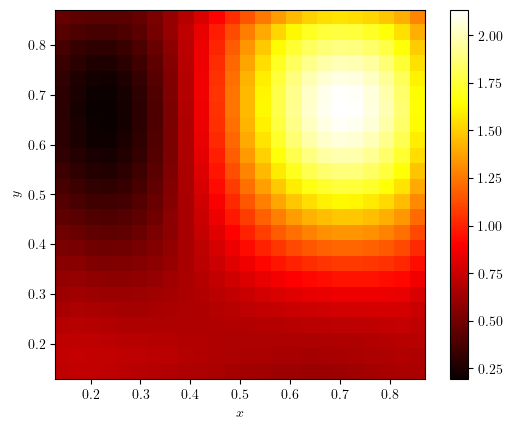

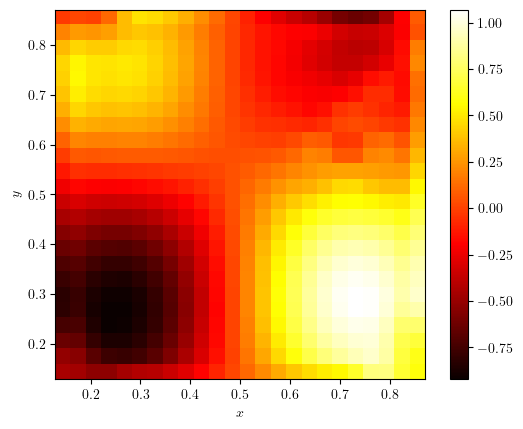

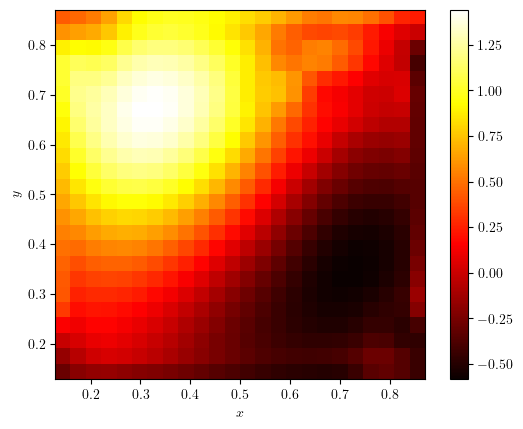

In [ ]:
#Viasualize the learned coefficients
plt.imshow(interpolated_coefs_a[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

plt.imshow(interpolated_coefs_bx[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

plt.imshow(interpolated_coefs_by[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

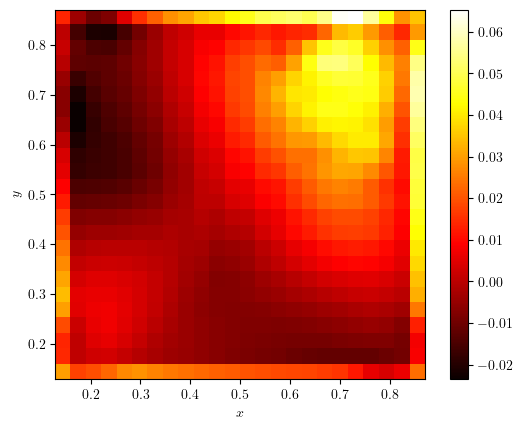

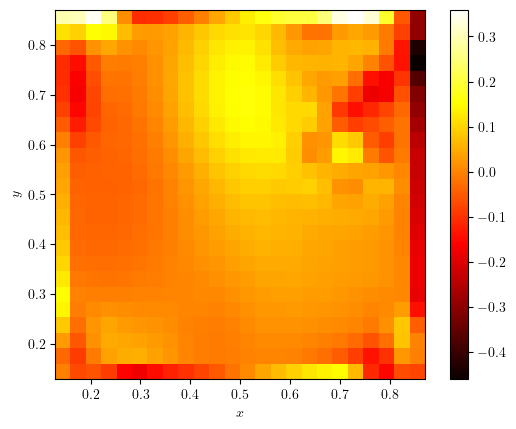

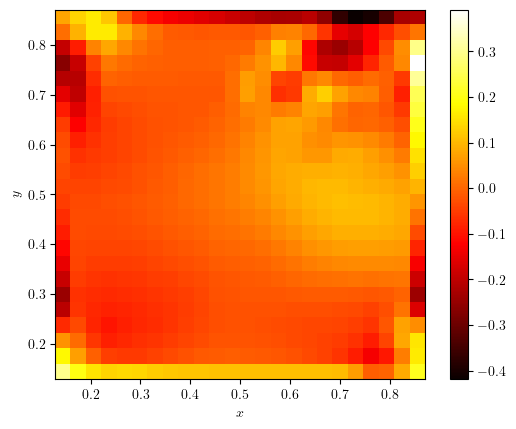

In [ ]:
#Plot the difference between the actual and learned coeffcients
plt.imshow(a_xy.cpu()[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor]-interpolated_coefs_a[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()
#Plot the difference between the actual and learned coeffcients
plt.imshow(b_x.cpu()[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor]-interpolated_coefs_bx[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

plt.imshow(b_y.cpu()[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor]-interpolated_coefs_by[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

# Plot an example of a modelled solution against its fully resolved function

Again interpolating to the fine grid for the modelled solution

In [ ]:
# Plot an example solution
sol_model_act = solutions_exact[test_data]

#Sample our solution to t_k time steps
sol_model_act_avg = torch.zeros((t_k, n_x, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred = model(inputs[test_data].unsqueeze(0)).squeeze(0).detach().cpu().numpy()

In [ ]:
#Interpolate our solution to the fine grid
test_time = 0
interp2d_sol = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                         sol_model_pred[test_time], bounds_error=False, fill_value=None)
interpolated_sol = interp2d_sol((x2, x1))

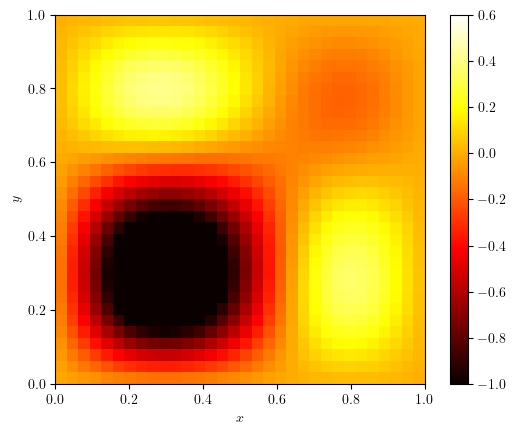

In [ ]:
#Plot our solutions to compare - modelled solution at first predicted time
plt.imshow(interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

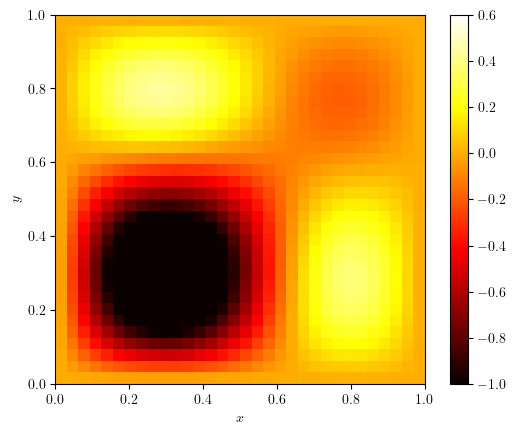

In [ ]:
#Plot our solutions to compare - actual solution at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
sol_model_act_avg[test_time]

tensor([[-4.7271e-04, -6.1191e-03, -1.2045e-02,  ...,  4.5538e-03,
          2.3539e-03,  1.8336e-04],
        [-6.1279e-03, -4.7735e-02, -9.3499e-02,  ...,  3.5464e-02,
          1.8422e-02,  2.1727e-03],
        [-1.2059e-02, -9.3454e-02, -1.8304e-01,  ...,  6.9366e-02,
          3.6028e-02,  4.2702e-03],
        ...,
        [ 5.0196e-03,  3.9048e-02,  7.6458e-02,  ..., -3.9287e-02,
         -2.0345e-02, -2.4805e-03],
        [ 2.5896e-03,  2.0237e-02,  3.9603e-02,  ..., -2.0316e-02,
         -1.0507e-02, -1.2735e-03],
        [ 2.0123e-04,  2.4084e-03,  4.7356e-03,  ..., -2.4941e-03,
         -1.2823e-03, -1.0470e-04]], device='cuda:0')

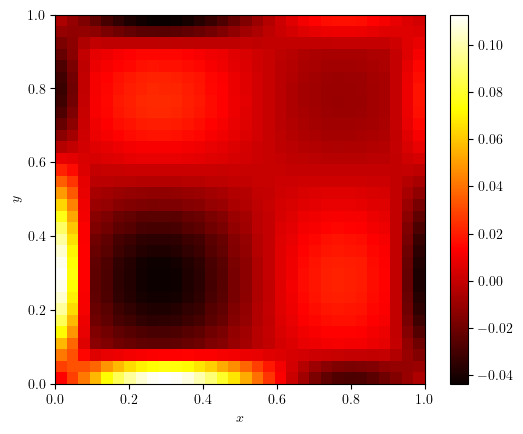

In [ ]:
#Plot our solutions to compare - difference in solutions at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu()-interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
#Maximum discrepancy between solutions at first predicted time
F.mse_loss(sol_model_act_avg[0],torch.tensor(interpolated_sol).to(device))


tensor(0.0006, device='cuda:0', dtype=torch.float64)

# Now we train a fuly connected neural net

## Working with the heat equaiton $$u_t = a(x,y)(u_{xx}+u_{yy})$$

Input data - Initial conditions

For now working with Zero-Dirichlet Boundary conditions

Initial conditions: $$u((x,y),0) = \sum_{i=1}^k \sum_{j=1}^kc_{ij}sin(\pi ix)\cdot sin(\pi jy)$$

$k = 2$ for the results presented today (note that larger $k$ values require finer grid size $n_x$ to generate good results).


In [ ]:
# Define the Coarsened FD method as a fully connected neural net
# Option 1: run the coede as is for the Convolutional neural netword
# Option 2: uncomment the section under #Define a simple 2-layer ReLU MLP, the comment # x = self.flatten(x) and the comment
# # y = y.view(-1, 1, self.grid_size, self.grid_size), and comment out the section under #Define a simple 2-layer ReLU conv net
# to run the fully connected network
class IndividualLayer_NN(nn.Module):
  """This class implements an individual layer of the coarsened grid FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(IndividualLayer_NN, self).__init__()

    self.grid_size = grid_size
    #Neural net is a simple fully-connected two-layer neural net with ReLU activation (i.e. we first flatten the inputs from a 2D array to a 1D array)
    self.layer1 = nn.Conv2d(1, 16, 3, 1, 1)
    self.activation = nn.ReLU()
    self.layer2 = nn.Conv2d(16, 1, 3, 1, 1)

    #Define a simple 2-layer ReLU MLP
    # self.flatten = nn.Flatten()
    # self.layer1 = nn.Linear(self.grid_size**2, 32)
    # self.activation = nn.ReLU()
    # self.layer2 = nn.Linear(32, self.grid_size**2)


  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs at a given time

      Outputs: Returns the predicted coarsened outputs at the next time
    """
    # x = self.flatten(x)
    #Conv layer 1
    x2 = self.layer1(x)
    #ReLU
    x3 = self.activation(x2)
    #Conv layer 2
    y = self.layer2(x3)
    #Re-shape to 2D array
    # y = y.view(-1, 1, self.grid_size, self.grid_size)
    return y

In [ ]:
class NN_Solver(nn.Module):
  """This class implements the Full Coarsened FD method"""

  def __init__(self, xmesh):
    """
      xmesh: int
        size of coarsened grid
      W: matrix
        Matrix for the coarsened FD method
    """
    super(NN_Solver, self).__init__()

    # Call the individual layer class defined previously - currently t_k = 10, change manually if this changes
    self.layer1 = IndividualLayer_NN(xmesh)
    self.layer2 = IndividualLayer_NN(xmesh)
    self.layer3 = IndividualLayer_NN(xmesh)
    self.layer4 = IndividualLayer_NN(xmesh)
    self.layer5 = IndividualLayer_NN(xmesh)
    self.layer6 = IndividualLayer_NN(xmesh)
    self.layer7 = IndividualLayer_NN(xmesh)
    self.layer8 = IndividualLayer_NN(xmesh)
    self.layer9 = IndividualLayer_NN(xmesh)
    self.layer10 = IndividualLayer_NN(xmesh)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs to the network at time 0

      Outputs: Returns the coarsened outputs at the next 10 times
    """

    # Call the individual layer (FD method) 10 times to generate the next t_k = 10 time predictions in the coarsened grid (as before need to clean up)
    x1=self.layer1(x)
    x2=self.layer2(x1)
    x3=self.layer3(x2)
    x4=self.layer4(x3)
    x5=self.layer5(x4)
    x6=self.layer6(x5)
    x7=self.layer7(x6)
    x8=self.layer8(x7)
    x9=self.layer9(x8)
    x10=self.layer10(x9)

    # Concatenate the outputs to check with the original coarsened outputs
    y = torch.cat((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10),1)
    return y

In [ ]:
# Define the model as the PDE_Solver class and feed in the coarsed grid size and average W matrix
# Optimize with Adam and our loss is the L_2 loss
# Note that a regularization of 0.0001 is used when the grid reslution is 64 x 64 to prevent the model from blowing up
modelNN = NN_Solver(n_x_new).to(device)
optimizerNN = optim.Adam(modelNN.parameters(), weight_decay=0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
resultsNN = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 1000

    for epoch in range(n_epochs):
        train_loss, train_time = train(modelNN, Heat_DataLoader_train, optimizerNN, criterion)
        valid_loss, valid_time = validate(modelNN, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        resultsNN["train_losses"].append(train_loss)
        resultsNN["train_times"].append(train_time)
        resultsNN["valid_losses"].append(valid_loss)
        resultsNN["valid_times"].append(valid_time)

    test_loss, test_time = validate(modelNN, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    resultsNN["test_loss"] = test_loss
    resultsNN["test_time"] = test_time

Epoch: 0
Train Loss: 0.23740821182727814 | Train Time: 0.430
Valid Loss: 0.2403447926044464 | Valid Time: 0.006
Epoch: 1
Train Loss: 0.2277708023786545 | Train Time: 0.041
Valid Loss: 0.23233382403850555 | Valid Time: 0.002
Epoch: 2
Train Loss: 0.21764039397239685 | Train Time: 0.039
Valid Loss: 0.22328662872314453 | Valid Time: 0.003
Epoch: 3
Train Loss: 0.2092449903488159 | Train Time: 0.034
Valid Loss: 0.2140679657459259 | Valid Time: 0.003
Epoch: 4
Train Loss: 0.200442311167717 | Train Time: 0.033
Valid Loss: 0.2022644281387329 | Valid Time: 0.002
Epoch: 5
Train Loss: 0.18809109330177307 | Train Time: 0.034
Valid Loss: 0.1870887130498886 | Valid Time: 0.002
Epoch: 6
Train Loss: 0.17299759089946748 | Train Time: 0.034
Valid Loss: 0.17184077203273773 | Valid Time: 0.002
Epoch: 7
Train Loss: 0.15721625089645386 | Train Time: 0.032
Valid Loss: 0.15691205859184265 | Valid Time: 0.002
Epoch: 8
Train Loss: 0.14410206377506257 | Train Time: 0.033
Valid Loss: 0.1449165791273117 | Valid Time

Text(0, 0.5, 'MSE')

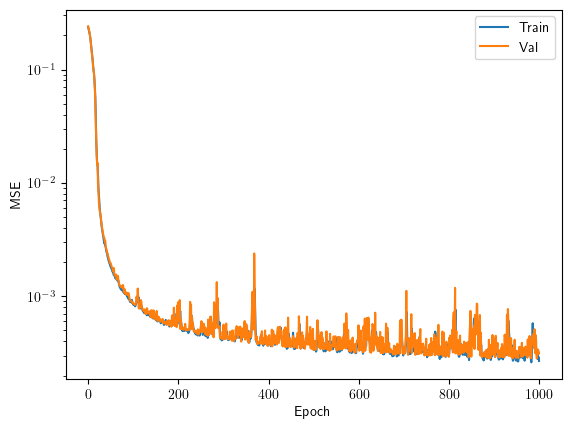

In [ ]:
# Plot the training and validation losses
plt.plot(resultsNN["train_losses"])
plt.plot(resultsNN["valid_losses"])
plt.legend(['Train', 'Val'])
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('MSE')

In [ ]:
# Plot an example solution
sol_model_act = solutions_exact[test_data]

#Sample our solution to t_k time steps
sol_model_act_avg = torch.zeros((t_k, n_x, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred_NN = modelNN(inputs[test_data].unsqueeze(0)).squeeze().detach().cpu().numpy()

In [ ]:
#Interpolate our solution to the fine grid
test_time = 0
interp2d_solNN = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                       sol_model_pred_NN[test_time], bounds_error=False, fill_value=None)
interpolated_solNN = interp2d_solNN((x2, x1))

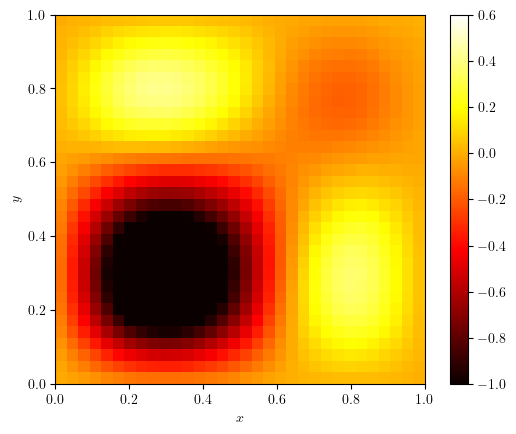

In [ ]:
#Plot our solutions to compare - modelled solution at first predicted time
plt.imshow(interpolated_solNN, cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

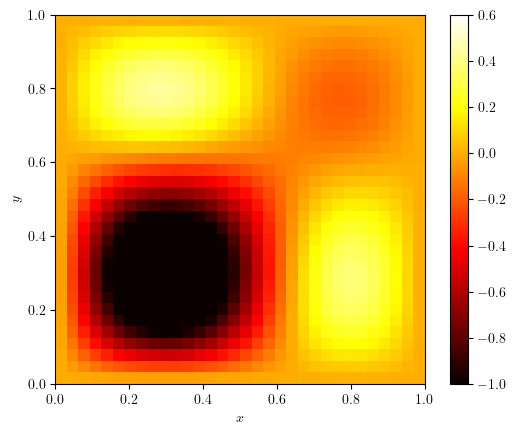

In [ ]:
#Plot our solutions to compare - exact solution at first predicted time
plt.imshow(sol_model_act_avg.cpu()[test_time], cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

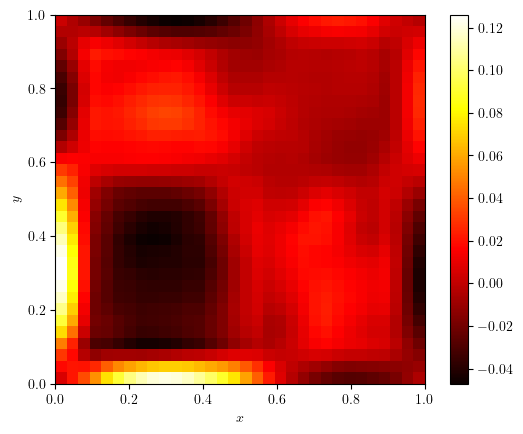

In [ ]:
#Plot our solutions to compare - dufference at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu()-interpolated_solNN, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
#Maximum discrepancy between solutions at first predicted time
F.mse_loss(sol_model_act_avg[0], torch.tensor(interpolated_solNN).to(device))

tensor(0.0007, device='cuda:0', dtype=torch.float64)

In [ ]:
#Get OOD losses
test_loss_OOD, test_time_OOD = validate(model, Heat_DataLoader_OOD, criterion)
test_loss_OOD_NN, test_time_OOD_NN = validate(modelNN, Heat_DataLoader_OOD, criterion)

In [ ]:
#Get normalization constants
u_avg_OOD = torch.mean(outputs_OOD)
u_stdev_OOD = torch.mean((outputs_OOD - u_avg_OOD)**2)

u_avg = torch.mean(outputs)
u_stdev = torch.mean((outputs - u_avg)**2)

In [ ]:
# Graph subgrids - note that this was done accros several runs, and the code needs to be uncommented and commented as needed
#to avoid overwriting the arrays and depending on the neural network model being run
factors = np.array([4096,1024,216,64])
losses_PDE_train = np.ones(4)
losses_PDE = np.ones(4)
losses_PDE_OOD = np.ones(4)
losses_NN_train = np.ones(4)
losses_NN = np.ones(4)
losses_NN_OOD = np.ones(4)
losses_Conv_train = np.ones(4)
losses_Conv = np.ones(4)
losses_Conv_OOD = np.ones(4)

In [ ]:
#Graph subgrids (adjust run and model as needed)
run = 3
losses_PDE_train[run-1] = (results["train_losses"][-1]/u_stdev)**0.5
losses_PDE[run-1] = (results["test_loss"]/u_stdev)**0.5
losses_PDE_OOD[run-1] = (test_loss_OOD/u_stdev_OOD)**0.5
# losses_NN_train[run-1] = (resultsNN["train_losses"][-1]/u_stdev)**0.5
# losses_NN[run-1] = (resultsNN["test_loss"]/u_stdev)**0.5
# losses_NN_OOD[run-1] = (test_loss_OOD_NN/u_stdev_OOD)**0.5
losses_Conv_train[run-1] = (resultsNN["train_losses"][-1]/u_stdev)**0.5
losses_Conv[run-1] = (resultsNN["test_loss"]/u_stdev)**0.5
losses_Conv_OOD[run-1] = (test_loss_OOD_NN/u_stdev_OOD)**0.5

In [ ]:
import matplotlib

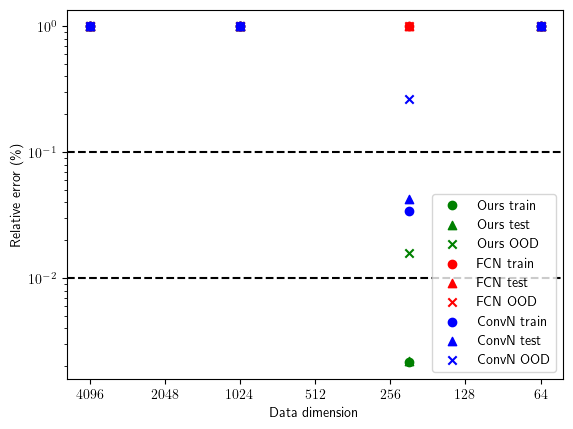

In [ ]:
#Graph subgrids
import matplotlib.ticker as mticker
plt.rc('axes.formatter', useoffset=False)

plt.scatter(factors, losses_PDE_train, c = 'green')
plt.scatter(factors, losses_PDE, c = 'green', marker = '^')
plt.scatter(factors, losses_PDE_OOD, c = 'green', marker = 'x')
plt.scatter(factors, losses_NN_train, c = 'red')
plt.scatter(factors, losses_NN, c = 'red', marker = '^')
plt.scatter(factors, losses_NN_OOD, c = 'red', marker = 'x')
plt.scatter(factors, losses_Conv_train, c = 'blue')
plt.scatter(factors, losses_Conv, c = 'blue', marker = '^')
plt.scatter(factors, losses_Conv_OOD, c = 'blue', marker = 'x')
plt.legend(['Ours train', 'Ours test', 'Ours OOD', 'FCN train', 'FCN test', 'FCN OOD', 'ConvN train', 'ConvN test', 'ConvN OOD'], loc = 4)

plt.xlabel('Data dimension')
plt.ylabel('Relative error (\%)')
plt.yscale('log')
plt.xscale('log', base = 2)
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().invert_xaxis()

plt.axhline(y = 0.1, color = 'black', linestyle = '--')
plt.axhline(y = 0.01, color = 'black', linestyle = '--')

plt.show()

In [ ]:
#Sample our solution to t_k time steps
visual = 9
OOD_avg = torch.zeros((t_k, n_x, n_x)).to(device)
for i in range (t_k):
  OOD_avg[i] = solutions_exact_OOD[visual][t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input for both models
OOD_pred_RCNN = model(inputs_OOD[visual+1].unsqueeze(0)).squeeze().detach().cpu().numpy()
OOD_pred_NN = modelNN(inputs_OOD[visual+1].unsqueeze(0)).squeeze().detach().cpu().numpy()

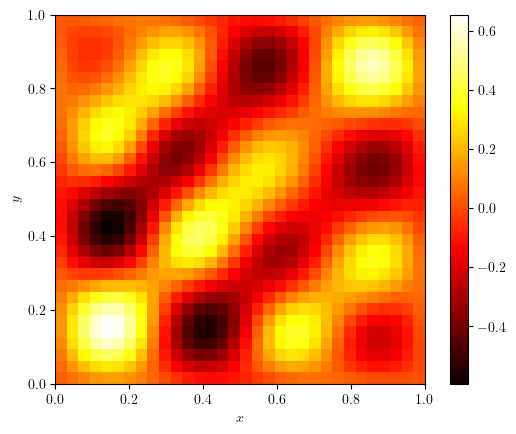

In [ ]:
test_time = 9
#Plot our solutions to compare - actual solution at first predicted time
plt.imshow(OOD_avg[test_time].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

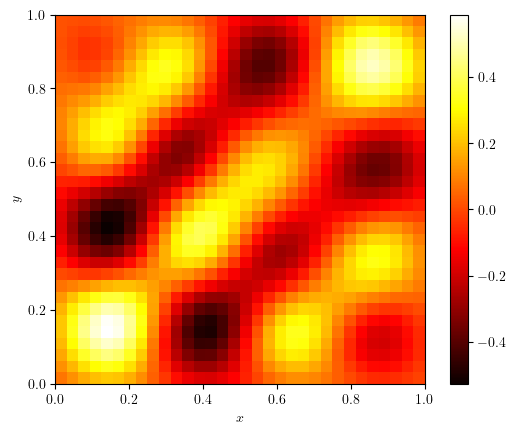

In [ ]:
#Plot our solutions to compare
interp2d_ood = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                         OOD_pred_RCNN[test_time], bounds_error=False, fill_value=None)
interpolated_ood = interp2d_ood((x2, x1))

#Plot our solutions to compare - predicted solution at first predicted time
plt.imshow(interpolated_ood, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

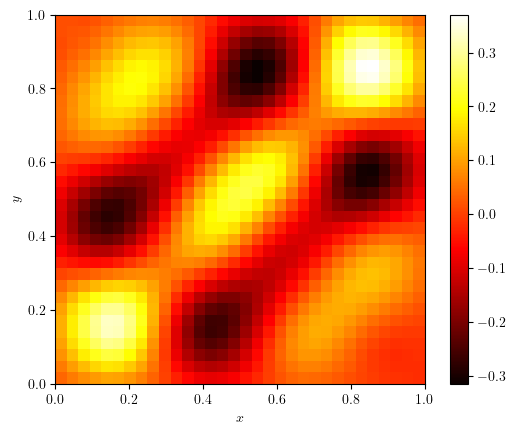

In [ ]:
#Interpolate our solution to the fine grid
interp2d_oodNN = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                          OOD_pred_NN[test_time], bounds_error=False, fill_value=None)
interpolated_oodNN = interp2d_oodNN((x2, x1))

#Plot our solutions to compare - predicted solution at first predicted time
plt.imshow(interpolated_oodNN, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

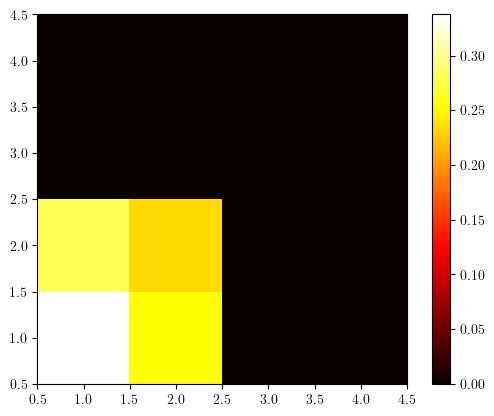

In [ ]:
#Visualize the decay of the coefficients
coefficient_mean = torch.mean(coefficients**2,0)
plt.imshow(coefficient_mean.cpu(), cmap='hot', origin='lower', extent=[0.5, 4.5, 0.5, 4.5])
plt.colorbar()

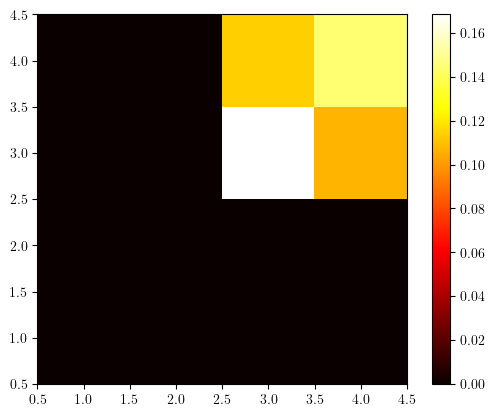

In [ ]:
#Visualize the decay of the coefficients
coefficient_mean_OOD = torch.mean(coefficients_OOD**2,0)
plt.imshow(coefficient_mean_OOD.cpu(), cmap='hot', origin='lower', extent=[0.5, 4.5, 0.5, 4.5])
plt.colorbar()